# Setup

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,Dropout,BatchNormalization,GlobalMaxPool1D,Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns; sns.set()
import string
import re
from nltk.tokenize import TweetTokenizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importação do Dataset

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Deep Learning 2020/deep_learning_2020_lista_3/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Deep Learning 2020/deep_learning_2020_lista_3/test.csv')

# Preprocessamento

In [ ]:
train_df.head()

In [ ]:
(train_df.isnull()==True).sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train_df[train_df['keyword'].isnull()==False]

In [ ]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train_df[train_df['id'].isin(ids_with_target_error)]

In [ ]:
train_df.loc[train_df['id'].isin(ids_with_target_error),'target'] = 0
train_df[train_df['id'].isin(ids_with_target_error)]

In [ ]:
train_df.loc[train_df['keyword'].notnull(), 'text'] = train_df['keyword'] + ' ' + train_df['text']

In [ ]:
def convert_abbrev_in_text(text):
    t = []
    words = text.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)  

In [ ]:
train_df['text'] = train_df['text'].apply(clean_data)
train_df['text'] = train_df['text'].apply(convert_abbrev_in_text)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

sequences = tokenizer.texts_to_sequences(train_df['text'])
pad = pad_sequences(sequences, maxlen=120, padding='post', truncating='post')

# Treinamento da LSTM

In [ ]:
partition = int(len(train_df)*0.8);
y_train = train_df['target'].iloc[0:partition]
y_test = train_df['target'].iloc[partition:len(train_df)]
X_train = pad[0:partition]
X_test = pad[partition:len(train_df)]

vocab_size=len(tokenizer.word_index)+1

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=pad.shape[1]))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Dropout(0.7))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.7))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           539616    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 64)           16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 120, 64)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 120, 64)           24832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 64)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_data=(X_test, y_test)
                    )

Epoch 1/10
191/191 [==============================] - 48s 251ms/step - loss: 0.6354 - accuracy: 0.6350 - val_loss: 0.5052 - val_accuracy: 0.7610
Epoch 2/10
191/191 [==============================] - 46s 241ms/step - loss: 0.3874 - accuracy: 0.8504 - val_loss: 0.4868 - val_accuracy: 0.7754
Epoch 3/10
191/191 [==============================] - 45s 238ms/step - loss: 0.2329 - accuracy: 0.9223 - val_loss: 0.5421 - val_accuracy: 0.7689
Epoch 4/10
191/191 [==============================] - 45s 237ms/step - loss: 0.1625 - accuracy: 0.9522 - val_loss: 0.6949 - val_accuracy: 0.7466
Epoch 5/10
191/191 [==============================] - 46s 240ms/step - loss: 0.1259 - accuracy: 0.9626 - val_loss: 0.8336 - val_accuracy: 0.7223
Epoch 6/10
191/191 [==============================] - 46s 240ms/step - loss: 0.0993 - accuracy: 0.9700 - val_loss: 0.8145 - val_accuracy: 0.7058
Epoch 7/10
191/191 [==============================] - 46s 241ms/step - loss: 0.0754 - accuracy: 0.9739 - val_loss: 1.4415 - val_ac

# Avaliação da performance da LSTM

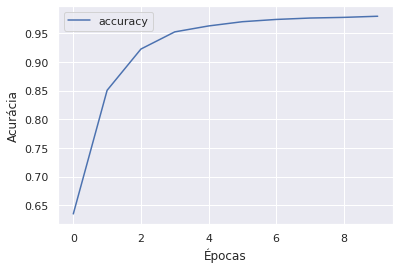

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [ ]:
test_val_df = train_df.sample(frac=0.25)

In [ ]:
test_val_df.loc[test_val_df['keyword'].notnull(), 'text'] = test_val_df['keyword'] + ' ' + test_val_df['text']
test_val_df['text'] = test_val_df['text'].apply(clean_data)

t_sequences = tokenizer.texts_to_sequences(test_val_df['text'])
t_pad = pad_sequences(t_sequences, maxlen=120, padding='post', truncating='post')

In [ ]:
predictions = model.predict(t_pad)

In [ ]:
predictions

array([[7.6399738e-05],
       [9.9999481e-01],
       [2.1456415e-05],
       ...,
       [2.2218097e-05],
       [2.2082353e-05],
       [9.9999535e-01]], dtype=float32)

In [ ]:
predictions_ = []
for i in range(len(predictions)):
  predictions_.append(np.round(predictions[i]))

In [ ]:
mat = tf.math.confusion_matrix(test_val_df['target'], predictions_)
mat

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[995,  88],
       [ 54, 766]], dtype=int32)>

Text(66.5, 0.5, 'predicted label')

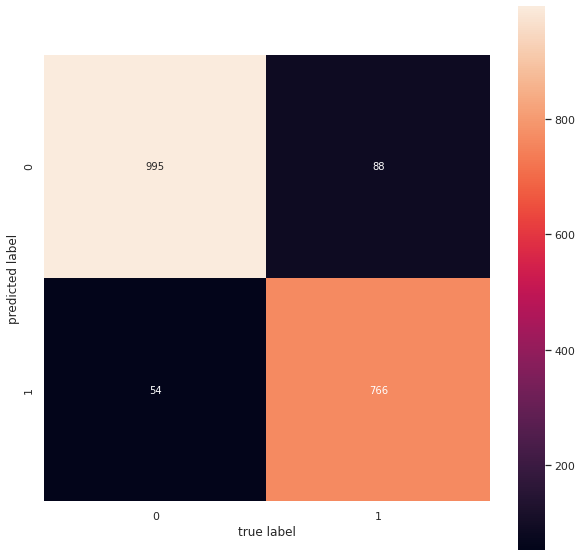

In [ ]:
plt.figure(figsize=(10,10))
ax= plt.subplot(111)
ax= sns.heatmap(mat, square=True, annot=True, fmt='g', cbar=True, ax=ax)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Fazendo previsões de novos dados

In [ ]:
test_df.loc[test_df['keyword'].notnull(), 'text'] = test_df['keyword'] + ' ' + test_df['text']
test_df['text'] = test_df['text'].apply(clean_data)

t_sequences = tokenizer.texts_to_sequences(test_df['text'])
t_pad = pad_sequences(t_sequences, maxlen=120, padding='post', truncating='post')

In [ ]:
predictions = model.predict(t_pad)

In [ ]:
predictions_ = []
for i in range(len(predictions)):
  predictions_.append(np.round(predictions[i]))

In [ ]:
test_df['predictions'] = predictions_